# Mechanism and start of soving  the DBD problem of Ar using FEncis

## Abstract

#### 1. 1D Poisson Eq'n의 풀이
 - 밀도 가정
 - 교류 적용 가능성 확인과 예상 값 확인
 

#### 2. 1D Boltzmann Eq'n 구현
 - Poisson Eq'n에 적용할 전하 밀도 계산 



## Solving 1D Eq'n

- 임의의 전하밀도, 시간을 가정하여 Poisson Eq'n을 풀이한다.
- 교류 전원의 적용 가능성을 확인한다.

In [ ]:
#*** Parameters for the of plasma reactor====================================================================
width=2.0                     #space between two dielectric in mm
ngrid0=300                    #Number of grid points (between two dielectric)
wd1=0.8                       #width of first dielectric in mm
wd2=0.8                       #width of second dielectric in mm
dx=width*10**(-3)/(ngrid0+1.0)#Grid size in meter
nwd1=int(wd1*10**(-3)/dx)     #number of grid points in first dielectric
nwd2=int(wd2*10**(-3)/dx)     #Number of grid points in second dielectric
wd1=nwd1*dx                   #Making wd1 as exact multiple of dx
wd2=nwd2*dx                   #making wd2 as exact multiple of dx
inelec=width*10**(-3)+wd1+wd2 #total interelectrode separation
ngrid=int(ngrid0+2+nwd1+nwd2) #total number of grid points(2 dielectrics +gas medium + all edge points)
#--------------------------------------------------------------------------------------------------------------
volt=5000.0                   #Interelectrode voltage (peak not RMS)
gasdens=2.504e25              #number density of gas at NTP (unit: m^-3)
dt=1.0e-10                    #small time interval
frequencySource =  41000       #in Hz
ee=1.6*10**(-19)              #electronic charge
e0=8.54187817*10**(-12)       #epsilon
townsendunit=1.0/((gasdens)*(10)**(-21))#townsend factor
Kboltz=1.380*10e-23           #Boltzmann constant
desorption=1*10.                #desorption coefficient
recombination=1e-10           #surface recombination coefficient
gamma=0.01                    #secondary electron emission coefficient

In [ ]:
 #                           *** POISSON'S EQUATION ***
    #-------------------------------------------------------------------------------------------
    netcharge[nwd1:nwd1+2+ngrid0]=ee*np.dot(ncharge,ndensity)   #calculating net charge
    netcharge[nwd1+1:nwd1+1+ngrid0]=0.                          #quasi neutrality condition
    leftPot=1.0*volt*np.sin(2*np.pi*time*frequencySource)       #applied voltage (left)
    rightpot=0.0*volt*np.sin(2*np.pi*time*frequencySource)      #applied voltage (right)
    chrgg=-(netcharge/e0)*dx*dx                                 #RHS matrix. <Read documentation>
    chrgg[0]=leftPot                                            #left boundary condition
    chrgg[-1]=rightpot                                          #right boundary condition
    potentl=la.spsolve(poissonSparseMatrix,chrgg)               #solving system of Matrix equations
    
    #**calculate electric field as negative gradient of potential (Expressed in Townsend Unit)
    efield[:]=-townsendunit*(potentl[nwd1+1:nwd1+3+ngrid0]-potentl[nwd1-1:nwd1+1+ngrid0])/(2.0*dx)
    efield[0]=-townsendunit*(-(11.0/6)*potentl[nwd1]+3.0*potentl[nwd1+1]-(3.0/2)*potentl[nwd1+2]+(1.0/3)*potentl[nwd1+3])/dx
    efield[-1]=-townsendunit*(potentl[nwd1+1+ngrid0]-potentl[nwd1+ngrid0])/dx
    
    if any(abs(efield[:])>995):#Stop the program if E>995 Townsends.
         sys.exit()
            
     
    #                           ***BOUNDARY *** (charge accumulation at surface of dielectric)
    #--------------------------------------------------------------------------------------------------------
    ndensity[:-1,0]=sigmaLR[:-1,0]/dx    #volume charge density approximation due to charge accumulation on left dielectric            
    ndensity[:-1,-1]=sigmaLR[:-1,1]/dx   #volume charge density approximation due to charge accumulation on left dielectric
    ndensity[:,ndensity[0]<0]=0.         #non-negative number of particles
 

In [1]:
from fenics import *
from dolfin import *
from mshr import *
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.sparse.linalg as la
import scipy.sparse as sparse
import time as tm

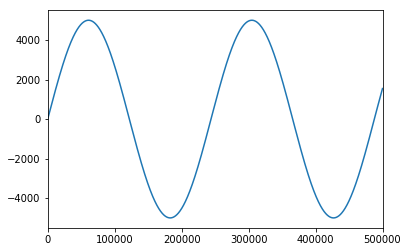

In [9]:
x=np.linspace(0,500000*10**(-10),500000)
leftPot=1.0*volt*np.sin(2*np.pi*x*41000)
plt.xlim(0,500000)
plt.plot(leftPot)

41000Hz의 진동수를 가지는 교류이므로 약 24us 마다 한 주기가 반복된다.  

교류 전류와 전압의 상관관계 확인을 위해 첫 번째 봉우리에 도달할 때 까지를 세 부분으로 나누어 비교한다.

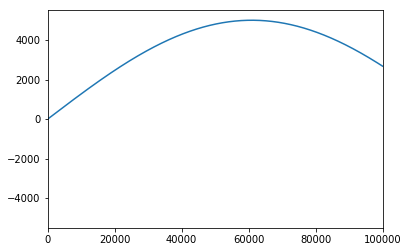

In [8]:
x=np.linspace(0,500000*10**(-10),500000)
leftPot=1.0*volt*np.sin(2*np.pi*x*41000)
plt.xlim(0,100000)
plt.plot(leftPot)

In [2]:
# parameter
time1 = 2.0*10**(-6) # secoond, dt = 0.1ns
time2 = 2*time1
time3 = 3*time1 # 1/4 주기
volt=5000 # Voltage 
frequencySource = 41000 # Hz

leftPot1=1.0*volt*np.sin(2*np.pi*time1*frequencySource)# 좌측 bc
leftPot2=1.0*volt*np.sin(2*np.pi*time2*frequencySource)
leftPot3=1.0*volt*np.sin(2*np.pi*time3*frequencySource)
rightPot=0 # 우측 bc

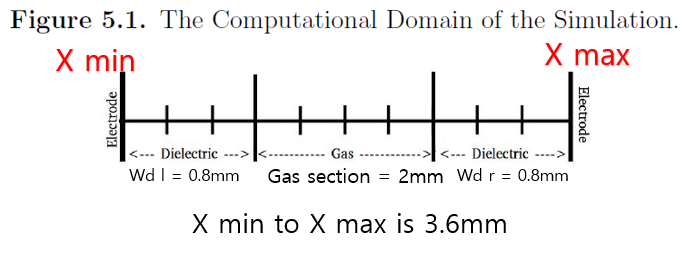

In [3]:
# Create Mesh and define function space

xmin = 0    # gird 가장 왼쪽
xmax = 3.6*10**(-3)    # grid 가장 오른쪽
wd_l=0.8*10**(-3) # width of left dielectric in  m
wd_r=0.8*10**(-3) # width of right dielectric in  m
mesh = IntervalMesh(360,xmin,xmax) # 3.6mm를 360등분한 직선 메쉬

rho =Expression("0",degree=2) # Assumed value

#######rho 함수 구현 방법########
#볼츠만 연속방정식으로 구한 밀도값들을 네 구역으로 나눠, 구역 별로 평균을 낸다(양 끝 점은 고정).
#보간법을 통해 네 점을 함수로 나타내어 입력한다.
#구역이 조밀할수록 정확하나, 함수로 나타내기에 어려움이 존재하므로 4개로 설정했다.

epsilon_Ar=8.54187817*10**(-12) # Ar 유전율
epsilon_DB=11.54 # 유전체 유전율

# Define Subdomain

tol = 1e-9
Dielectric_area='x[0]<=0.8/1000-tol or x[0]>=2.8/1000+tol ? epsilon_DB : epsilon_Ar'
epsilon = Expression(Dielectric_area, degree=0, tol=tol, epsilon_Ar=epsilon_Ar, epsilon_DB=epsilon_DB)

p=1

X = FunctionSpace(mesh,"Lagrange",p)

In [4]:
# Define boundary condition

def boundry_left(x , on_boundry):
    return on_boundry and x[0] < tol

def boundry_right(x , on_boundry):
    return on_boundry and x[0] > (3.6*10**(-3))-tol

bc_l = DirichletBC(X, leftPot1, boundry_left)
bc_r = DirichletBC(X, rightPot, boundry_right)
bcs = [bc_l, bc_r]

# Define variational proble
V = TrialFunction(X)
v = TestFunction(X)
a = dot(epsilon*grad(V), grad(v))*dx
L = rho*v*dx

# Compute solution
V1 = Function(X)
solve(a == L, V1, bcs)

In [5]:
bc_l = DirichletBC(X, leftPot2, boundry_left)
bc_r = DirichletBC(X, rightPot, boundry_right)
bcs = [bc_l, bc_r]

# Define variational proble
V = TrialFunction(X)
v = TestFunction(X)
a = dot(epsilon*grad(V), grad(v))*dx
L = rho*v*dx

# Compute solution
V2 = Function(X)
solve(a == L, V2, bcs)

In [6]:
bc_l = DirichletBC(X, leftPot3, boundry_left)
bc_r = DirichletBC(X, rightPot, boundry_right)
bcs = [bc_l, bc_r]

# Define variational proble
V = TrialFunction(X)
v = TestFunction(X)
a = dot(epsilon*grad(V), grad(v))*dx
L = rho*v*dx

# Compute solution
V3 = Function(X)
solve(a == L, V3, bcs)

([<matplotlib.lines.Line2D at 0x7f4be4125390>],
 [<matplotlib.lines.Line2D at 0x7f4be4125a20>])

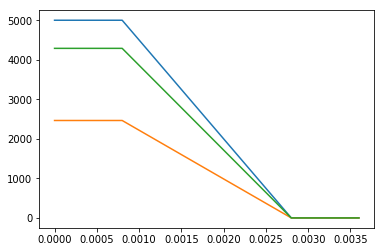

In [7]:
plot(V3), plot(V1), plot(V2)

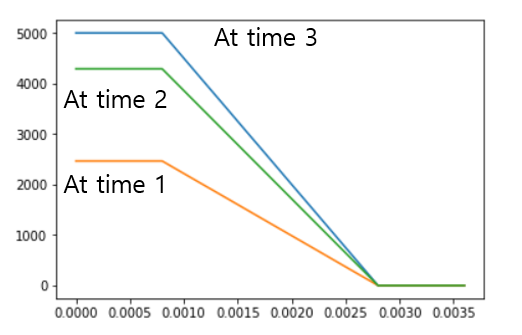

- time 1, time 2, time 3은 각각 2us, 4us, 6us의 전압을 나타낸다.
- 6us에서 최대값인 5000V을 갖는 다는 것을 확인할 수 있다.
- 시간에 따라 왼쪽 유전물질에 인가되는 전압이 커짐을 알 수 있다.
- 우측 유전물질의 전압을 0으로 설정했고, 임의로 전하밀도를 0으로 지정하여 일정하게 감소한다.

## Trying to slove Boltzmann Eq'n

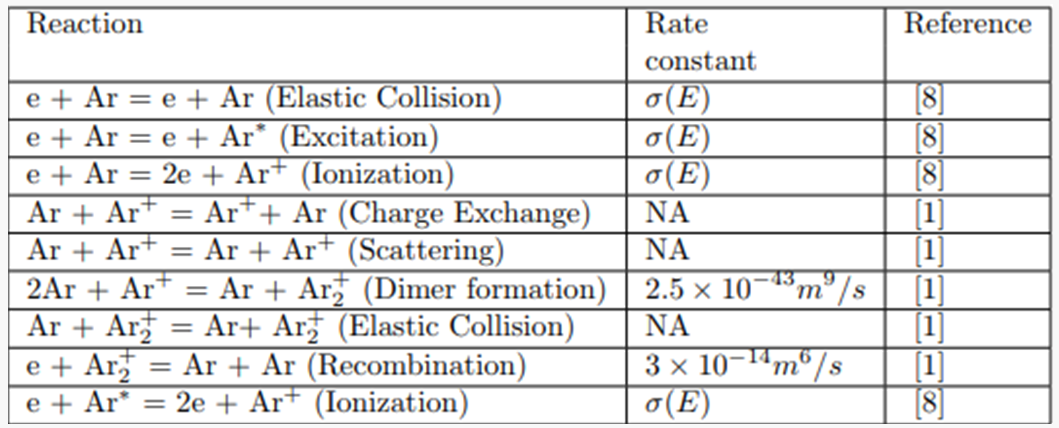

In [ ]:
timeseries_w = TimeSeries('Continuity/velocity_series')
# velocity_series 에 대한 내용을 아직 발견하지 못함

In [ ]:
#initialization

mu1 = 1   # 전기장, 전자 평균 에너지에 따라 bolsig에서 구해야 함
mu2 = 1
mu3 = 1
mu4 = 1
d1 = 1
d2 = 1
d3 = 1
d4 = 1
k1 = 1
k2 = 1
k3 = 1
k4 = 1
k5 = 1

In [ ]:
T = 2*10**(-6)     # final time
num_steps = 3      # number of time steps
dt = T / num_steps # time step size

# create mesh
xmin = 0.8
xmax = 2.8
mesh = IntervalMesh(300,xmin,xmax)

# Define function space for velocity
W = VectorFunctionSpace(mesh, 'P', 1)

# Define function space for system of concentration
P1 = FiniteElement('P',"interval", 1)
element = MixedElement([P1, P1, P1, P1])
V = FunctionSpace(mesh, element)

# Define test functions
v_1, v_2, v_3, v_4 = TestFunctions(V)

# Define functions for velocity and concentrations
w = Function(W)
u = Function(V)
u_n = Function(V)

# Split system functions to acces components
u_1, u_2, u_3, u_4 = split(u)
u_n1, u_n2, u_n3, u_n4 = split(u_n)

# Define expressions used in variational forms
k = Constant(dt)
K1 = Constant(k1)
K2 = Constant(k2)
K3 = Constant(k3)
K4 = Constant(k4)
K5 = Constant(k5)
D1 = Constant(d1)
D2 = Constant(d2)
D3 = Constant(d3)
D4 = Constant(d4)


# Define variational problem
F = ((u_1 - u_n1) / k)*v_1*dx + dot(w, grad(u_1))*v_1*dx \
+ D1*dot(grad(u_1), grad(v_1))*dx + K1*u_1*u_2*v_1*dx \
+ ((u_2 - u_n2) / k)*v_2*dx + dot(w, grad(u_2))*v_2*dx \
+ D2*dot(grad(u_2), grad(v_2))*dx + K2*u_1*u_2*v_2*dx \
+ ((u_3 - u_n3) / k)*v_3*dx + dot(w, grad(u_3))*v_3*dx \
+ D3*dot(grad(u_3), grad(v_3))*dx - K3*u_1*u_2*v_3*dx + K3*u_3*v_3*dx \
+ ((u_4 - u_n4) / k)*v_4*dx + dot(w, grad(u_4))*v_4*dx \
+ D4*dot(grad(u_4), grad(v_4))*dx - K4*u_1*u_2*v_3*dx + K4*u_3*v_3*dx \

# Create time series for reading velocity data
timeseries_w = TimeSeries('Continuity/velocity_series')

# Create VTK files for visualization output
vtkfile_u_1 = File('Continuity/u_1.pvd')
vtkfile_u_2 = File('Continuity/u_2.pvd')
vtkfile_u_3 = File('Continuity/u_3.pvd')
vtkfile_u_4 = File('Continuity/u_4.pvd')


# Time-stepping
t = 0
for n in range(num_steps):
    
    # Update current time
    t += dt
    
    # Read velocity from file
    timeseries_w.retrieve(w.vector(), t)
    
    # Solve variational problem for time step
    solve(F == 0, u)
    
    # Save solution to file (VTK)
    _u_1, _u_2, _u_3, _u_4 = u.split()
    vtkfile_u_1 << (_u_1, t)
    vtkfile_u_2 << (_u_2, t)
    vtkfile_u_3 << (_u_3, t)
    vtkfile_u_4 << (_u_4, t)
    
    # Update previous solution
    u_n.assign(u)
    
    # Update progress bar
    progress.update(t / T)
    
# Hold plot
interactive()

In [ ]:
# Setting initial conditions
u_0 = Expression(('sin(1000*x[0])', 'sin(2000*x[0])', 'sin(3000*x[0])', 'sin(4000*x[0])'), degree=1)  # 초기 밀도 조건으로서 난수로 지정해주어야함 (매우 작은 수)
u_n = project(u_0, V)

In [ ]:
tol=1E-3
def boundary_1(x, on_boundary):
    return on_boundary and near(x[0], 0, tol)

u_D = Expression('3', degree=1)   # Boundary condition은 전하 축적 방정식으로부터 가져와야 한다. 본 예시에는 3으로 임의로 지정.
bc = DirichletBC(V.sub(1), u_D, boundary_1)


## The mechanism that we will try

1. 볼츠만 방정식을 이용해 Gas section의 전하밀도를 구한다.  


2. Gas section의 전하밀도를 4 등분하여 각 구역별로 전하밀도 평균을 구한다. 


3. Gas section의 양 끝점을 포함한 5 점을 4차 방정식으로 근사한다.  


4. 이 값을 Poisson eq'n의 전하밀도항에 대입하여 계산을 실시한다.


5. for문을 활용하여 1~4를 반복한다.

## Some tasks we need to deal with

1. Botzmann eq'n 풀이를 구현해본다.


2. Boltzmann eq'n의 $mu$, D, k의 절적한 사용값으 Bolsig+를 이용하여 찾는다.  


3. 전하 밀도를 다항식으로 나타내는 방법을 찾는다.


4. for문을 구현한다.